In [1]:
import csv
import datetime
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import xgboost as xgb
import math

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow import keras
from tensorflow.keras import models, optimizers
from tensorflow.keras.layers import Dense, BatchNormalization
from yellowbrick.regressor import ResidualsPlot

import seaborn as sns;
sns.set_style('whitegrid')

### Read Data

We take the splited train and test dataset generated from the **preprocess.ipynb** as input.

In [2]:
def read_from_csv(path):
    df = pd.read_csv(path, index_col=0)
    return df

In [3]:
train_path = './data/train.csv'
test_path = './data/test.csv'

X_train, X_test = read_from_csv(train_path, ), read_from_csv(test_path)
len(X_train), len(X_test)

(956868, 239217)

In [4]:
y_train, y_test = pd.DataFrame(X_train['duration']), pd.DataFrame(X_test['duration'])

X_train.drop(columns=['duration'], inplace=True)
X_test.drop(columns=['duration'], inplace=True)

Here, we apply the [root-mean-square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (RMSE) as the metric for regression.

In [5]:
def get_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

# Model 

Our task is to build a regression model to predict the duration of a yellow taxi trip. We apply linear regression model as our baseline model. To capture the non-linear relationship between features and target, we further use XgBoost, Gradient Boost, Random Forest and Neural Networks for prediction. We implement parameter searching and tuning for those models to get the best results. We take root mean square error as evaluation metric. Finally, we plan to compare and analyze among different models.

## Linear Regression

For linear regression model, we choose four different variations. The simplest version of linear model shows as follow:
$$ \hat y = w_{1}x_{1} + w_{1}x_{1} + ... w_{n}x_{n} + b $$

The cost function is:
$$ \sum_{i=1}^{N} (y_{i} - w_{i}^{T} x_{i}) $$

For Ridge regression, the cost function consists of loss and regularization part. Regularization part equals to square of the magnitude of the coefficients:
$$ \sum_{i=1}^{N} (y_{i} - w_{i}^{T} x_{i}) + \lambda \sum_{j=0}^{F}w_{j}^{2}$$

For Lasso regression, regularization part of cost function is sum of absolute value of weights. This L1 regularization can shrink and completely neglect some of the features:
$$ \sum_{i=1}^{N} (y_{i} - w_{i}^{T} x_{i}) + \lambda \sum_{j=0}^{F}|w_{j}|$$

For [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) regression, it combines both L1 and L2 regularization into cost function.

Through the test, we find normalization will make performance worse, so we choose to use the default "normalize=False".

In [6]:
# https://scikit-learn.org/stable/modules/linear_model.html
model_lr = LinearRegression().fit(X_train, y_train)
model_ridge = Ridge().fit(X_train, y_train)
model_lasso = Lasso().fit(X_train, y_train)
model_elasticnet = ElasticNet().fit(X_train, y_train)

In [7]:
# Train
y_pred1 = model_lr.predict(X_train)
y_pred2 = model_ridge.predict(X_train)
y_pred3 = model_lasso.predict(X_train)
y_pred4 = model_elasticnet.predict(X_train)

train_loss1 = get_rmse(y_train, y_pred1)
train_loss2 = get_rmse(y_train, y_pred2)
train_loss3 = get_rmse(y_train, y_pred3)
train_loss4 = get_rmse(y_train, y_pred4)

print("Train Loss for Linear Regression: {}".format(train_loss1))
print("Train Loss for Ridge Regression: {}".format(train_loss2))
print("Train Loss for Lasso Regression: {}".format(train_loss3))
print("Train Loss for Elastic_Net Regression: {}".format(train_loss4))

Train Loss for Linear Regression: 1.7834652352866807
Train Loss for Ridge Regression: 1.7835177370940347
Train Loss for Lasso Regression: 2.503807148368556
Train Loss for Elastic_Net Regression: 2.8949032908463597


In [8]:
# Test
y_pred1 = model_lr.predict(X_test)
y_pred2 = model_ridge.predict(X_test)
y_pred3 = model_lasso.predict(X_test)
y_pred4 = model_elasticnet.predict(X_test)

test_loss1 = get_rmse(y_test, y_pred1)
test_loss2 = get_rmse(y_test, y_pred2)
test_loss3 = get_rmse(y_test, y_pred3)
test_loss4 = get_rmse(y_test, y_pred4)

print("Test Loss for Linear Regression: {}".format(test_loss1))
print("Test Loss for Ridge Regression: {}".format(test_loss2))
print("Test Loss for Lasso Regression: {}".format(test_loss3))
print("Test Loss for Elastic_Net Regression: {}".format(test_loss4))

Test Loss for Linear Regression: 1.7435271772038816
Test Loss for Ridge Regression: 1.7434671468032092
Test Loss for Lasso Regression: 2.4654423221141974
Test Loss for Elastic_Net Regression: 2.8573290279515997


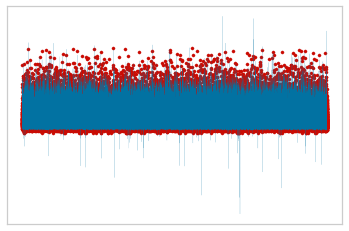

In [9]:
# Plot output, take "model_lr" as example
plt.scatter(np.arange(X_test.shape[0]), y_test, color='r', s=10)
plt.plot(np.arange(X_test.shape[0]), y_pred1, color='b', linewidth=0.1)

plt.xticks(())
plt.yticks(())
plt.show()

## XGBoost

Xgboost uses K additive functions to predict the output. The output is sum of scores predicted by each of the tree. Instead learning weights like in linear regression, XgBoost is learning functions (trees) in each iteration.

The objective funcion consists of train loss and regularization part. The training process starts from constant output. At each time add a new function which minimize the above objective function:

$$ Obj^{t} = \sum_{i=1}^{n} l(y_{i}, \hat {y_{i}}^{t-1}+f_{t}(x_{i})) + \Omega (f_{t}) \quad f_{t} \subseteq F \, (all \, regression \, trees) $$

In [10]:
params = { 
    'booster': 'gbtree',
    'objective':'reg:linear',
    'learning_rate': 0.2,
    'n_estimators': 200,
    'objective': 'reg:linear',  
    'gamma': 0.3,                  # control pruning
    'max_depth':5 ,               
    'lambda': 2,                   # L2 parameter
    'subsample': 0.8,              # random sample 
    'colsample_bytree': 0.7,       # col sample when generate tree
    'min_child_weight': 1,
    'silent': 0,
    'reg_alpha': 0
}

In [11]:
model_xgboost = xgb.XGBRegressor(
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        booster=params['booster'],
        objective=params['objective'],
        n_jobs=-1,
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=0,
        silent=params['silent'],
        max_depth=params['max_depth'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        reg_alpha=params['reg_alpha']
    )

model_xgboost.fit(X_train, y_train)

[01:00:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.3,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=0,
             subsample=0.8, verbosity=1)

In [12]:
# Train
y_pred = model_xgboost.predict(X_train)
train_loss = get_rmse(y_train, y_pred)
print("Train Loss: {}".format(train_loss))

Train Loss: 1.4620575919866792


In [13]:
# Test
y_pred = model_xgboost.predict(X_test)
test_loss = get_rmse(y_test, y_pred)
print("Test Loss: {}".format(test_loss))

Test Loss: 1.453725066348225


### Grid Search Parameters for Xgboost

Considering time complexity and effect on result, we choose "learning rate", "number of estimators" and "gamma" as tunning parameter. 

In [ ]:
# A parameter grid for XGBoost
params = {
        'booster': 'gbtree',
        'objective':'reg:squarederror',
        'max_depth': 5,
        'lambda': 2,                   # L2 parameter
        'subsample': 0.8,              # random sample
        'colsample_bytree': 0.7,       # col sample when generate tree
        'min_child_weight': 1,
        'reg_alpha': 0,
        'verbosity':1
    }

search_params={
        'learning_rate': [0.1, 0.2, 0.3],
        'n_estimators': [100, 200, 300],
        'gamma': [1, 2, 5, 10],
    }

model_xgboost = xgb.XGBRegressor(
        booster=params['booster'],
        objective=params['objective'],
        n_jobs=-1,
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=0,
        max_depth=params['max_depth'],
        min_child_weight=params['min_child_weight'],
        reg_alpha=params['reg_alpha'],
        verbosity=params['verbosity']
    )

cv_folders = 5
gs = GridSearchCV(model_xgboost, search_params, scoring="neg_mean_absolute_error", cv=cv_folders, verbose=2)
gs.fit(X_train, y_train)

In [ ]:
print(gs.scorer_, gs.best_estimator_, gs.best_params_, gs.best_score_)

In [14]:
# best model: gs.best_estimator_
best_xgboost = xgb.XGBRegressor(
                base_score=0.5,
                booster='gbtree',
                colsample_bylevel=1,
                colsample_bynode=1,
                colsample_bytree=0.7,
                gamma=5,
                importance_type='gain',
                learning_rate=0.2,
                max_delta_step=0,
                max_depth=5,
                min_child_weight=1,
                missing=None,
                n_estimators=300,
                n_jobs=-1,
                nthread=None,
                objective='reg:squarederror',
                random_state=0,
                reg_alpha=0,
                reg_lambda=1,
                scale_pos_weight=1,
                seed=None,
                silent=None,
                subsample=0.8,
                verbosity=1)

best_xgboost.fit(X_train, y_train)

y_pred = best_xgboost.predict(X_train)
train_loss_xgboost = get_rmse(y_train, y_pred)
y_pred = model_xgboost.predict(X_test)
test_loss_xgboost = get_rmse(y_test, y_pred)

[0.00535351 0.45325422 0.00389996 0.00432467 0.00090386 0.00198223
 0.06814352 0.01176469 0.3634828  0.00093125 0.03720298 0.00744306
 0.00222272 0.00449821 0.03459238]


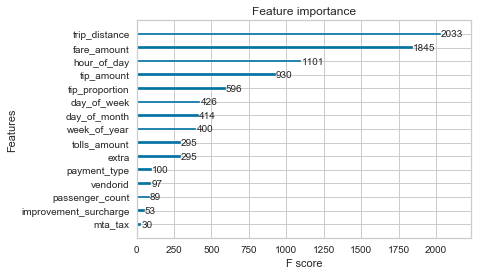

In [15]:
print(best_xgboost.feature_importances_)
xgb.plot_importance(best_xgboost)

## Random Forest

Random forest builds on bagging by random selecting samples, features and getting result from random set of predictors.


In [17]:
model_rf = RandomForestRegressor(n_jobs=-1, max_depth=10, verbose=True).fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    5.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.3s finished


In [18]:
# Train
y_pred = model_rf.predict(X_train)
train_loss_rf = get_rmse(y_train, y_pred)
print("Train Loss: {}".format(train_loss_rf))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


Train Loss: 1.524953470275133


In [19]:
# Test
y_pred = model_rf.predict(X_test)
test_loss_rf = get_rmse(y_test, y_pred)
print("Test Loss: {}".format(test_loss_rf))

Test Loss: 1.5143847534368304


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
from sklearn.tree import export_graphviz
from graphviz import Source
estimator = model_rf.estimators_[1]

from IPython.display import SVG
graph = Source(export_graphviz(estimator, out_file=None, feature_names=X_train.columns))
SVG(graph.pipe(format='svg'))

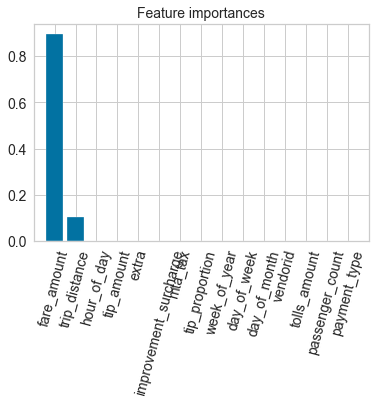

In [21]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
columns = X_train.columns.tolist()

plt.title("Feature importances", fontsize=14)
plt.bar(range(X_train.shape[1]), importances[indices], color="b",align="center")
plt.xticks(range(X_train.shape[1]), [columns[idx] for idx in indices], rotation=75, fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Gradient Boost

The objective of gradient boost is to minimize the loss of the model by adding decision tree one at a time using gradient descent. 

In [22]:
model_gb = GradientBoostingRegressor(verbose=True).fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1          65.6685            2.58m
         2          56.1638            2.25m
         3          48.3829            2.11m
         4          42.0387            2.04m
         5          36.8697            1.99m
         6          32.6104            1.93m
         7          29.1025            1.91m
         8          26.1356            1.86m
         9          23.6420            1.83m
        10          21.4276            1.80m
        20          10.9620            1.54m
        30           7.8556            1.30m
        40           6.5237            1.08m
        50           5.5924           52.93s
        60           4.7816           41.51s
        70           4.2468           30.71s
        80           3.8697           20.40s
        90           3.5383           10.14s
       100           3.3057            0.00s


In [23]:
# Train
y_pred = model_gb.predict(X_train)
train_loss_gb = get_rmse(y_train, y_pred)
print("Train Loss: {}".format(train_loss_gb))

Train Loss: 1.8181625042199774


In [24]:
# Test
y_pred = model_gb.predict(X_test)
test_loss_gb = get_rmse(y_test, y_pred)
print("Test Loss: {}".format(test_loss_gb))

Test Loss: 1.7734823871663308


## Neural Networks

In [25]:
# https://keras.io/getting-started/sequential-model-guide/
model_nn = models.Sequential()
model_nn.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model_nn.add(BatchNormalization())
model_nn.add(Dense(64, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(32, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(8, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(1))

optimizer = optimizers.Adam(lr=1e-4)
model_nn.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [26]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2048      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 2

In [27]:
history = model_nn.fit(
                x=X_train,
                y=y_train,
                validation_data=(X_test, y_test), 
                batch_size=256,
                epochs=8,
                shuffle=True,
                verbose=1
            )

Train on 956868 samples, validate on 239217 samples
Epoch 1/8
956868/956868 [==============================] - 11s 11us/sample - loss: 205.2713 - mae: 13.7156 - val_loss: 145.9162 - val_mae: 11.9723
Epoch 2/8
956868/956868 [==============================] - 10s 10us/sample - loss: 98.6723 - mae: 9.6523 - val_loss: 56.2324 - val_mae: 7.3333
Epoch 3/8
956868/956868 [==============================] - 10s 10us/sample - loss: 22.7601 - mae: 4.1894 - val_loss: 4.6421 - val_mae: 1.6515
Epoch 4/8
956868/956868 [==============================] - 10s 10us/sample - loss: 3.2495 - mae: 1.1380 - val_loss: 2.3305 - val_mae: 0.8597
Epoch 5/8
956868/956868 [==============================] - 10s 11us/sample - loss: 2.8635 - mae: 1.0259 - val_loss: 2.4961 - val_mae: 0.8523
Epoch 6/8
956868/956868 [==============================] - 10s 11us/sample - loss: 2.8079 - mae: 1.0133 - val_loss: 2.2980 - val_mae: 0.8533
Epoch 7/8
956868/956868 [==============================] - 10s 11us/sample - loss: 2.7835 - m

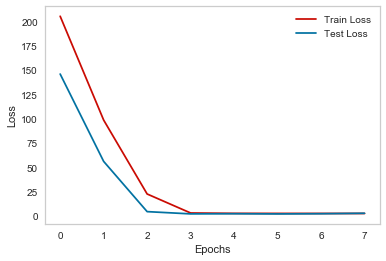

In [28]:
train_loss_nn = history.history['loss']
test_loss_nn = history.history['val_loss']
epochs = np.arange(len(train_loss_nn))

plt.plot(epochs, train_loss_nn, 'r')
plt.plot(epochs, test_loss_nn, 'b')
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

## Model Comparison

In [31]:
print('Train RMSE score for the Linear Regression model is : %f'%(train_loss1))
print('Train RMSE score for the Ridge model is : %f'%(train_loss2))
print('Train RMSE score for the Lasso model is : %f'%(train_loss3))
print('Train RMSE score for the ElasticNet model is : %f'%(train_loss4))
print('Train RMSE score for the Random Forest model is : %f'%(train_loss_rf))
print('Train RMSE score for the Gradient Boost model is : %f'%(train_loss_gb))
print('Train RMSE score for the Xgboost model is : %f'%(math.sqrt(train_loss_xgboost)))
print('Train RMSE score for the Neural Network is : %f'%(math.sqrt(train_loss_nn[-1])))

Train RMSE score for the Linear Regression model is : 1.783465
Train RMSE score for the Ridge model is : 1.783518
Train RMSE score for the Lasso model is : 2.503807
Train RMSE score for the ElasticNet model is : 2.894903
Train RMSE score for the Random Forest model is : 1.524953
Train RMSE score for the Gradient Boost model is : 1.818163
Train RMSE score for the Xgboost model is : 1.197815
Train RMSE score for the Neural Network is : 1.656447


1.2057052153607966

In [32]:
print('Test RMSE score for the Linear Regression model is : %f'%(test_loss1))
print('Test RMSE score for the Ridge model is : %f'%(test_loss2))
print('Test RMSE score for the Lasso model is : %f'%(test_loss3))
print('Test RMSE score for the ElasticNet model is : %f'%(test_loss4))
print('Test RMSE score for the Random Forest model is : %f'%(test_loss_rf))
print('Test RMSE score for the Gradient Boost model is : %f'%(test_loss_gb))
print('Test RMSE score for the Xgboost model is : %f'%(math.sqrt(test_loss_xgboost)))
print('Test RMSE score for the Neural Network is : %f'%(math.sqrt(test_loss_nn[-1])))

Test RMSE score for the Linear Regression model is : 1.743527
Test RMSE score for the Ridge model is : 1.743467
Test RMSE score for the Lasso model is : 2.465442
Test RMSE score for the ElasticNet model is : 2.857329
Test RMSE score for the Random Forest model is : 1.514385
Test RMSE score for the Gradient Boost model is : 1.773482
Test RMSE score for the Xgboost model is : 1.205705
Test RMSE score for the Neural Network is : 1.721494


# Summary

In this project, we extract yellow taxi data from NYC Open Data, conduct data analysis, feature engineering and use four models to predict trip duration. From above comparison, we can obtain following conclusions:

- Linear regression and its variations are treated as our baseline model. On both train set and test set, they got higher RMSE score. Among simple linear regression, ridge, lasso and elastic net, ridge model had slightly better performance on test set. 

- Compared with linear model, random forest model has about 15% lower RMSE both on train set and test set.

- Performace of gradien boost model is worse than random forest which may cause from inappropriate selection of some hyper-parameter. 

- Xgboost model achieve lowest RMSE score on train set and test set. It is an optimized distributed gradient boosting method which leads to both greater performance and less time cost.

During the whole project, we experienced the full data science development cycle. We noticed the importance of exploring and cleaning data before building models. And after understaning data and building baseline, we continually improve our feature analysis and selection based on baseline results until we get the optimal features. Then we use optimal feature space to build models and achieve best result. In the future, we want to go deeper with each models and compare them with different aspects.